# Práctica EigenFaces
## Gabriel Daniel Aguilar Luna, Zuriel Uzai Rodrígez Agiss
### _Facultad de Ingenierría, Universidad Nacional Autónoma de México_
### _Ciudad de México, México_
#### gabriel.aguilar@ingenieria.unam.edu,  zurieluzai2015@gmail.com

***

### __Desarrollo__

##### Imports y funciones

In [1]:
import sys
import numpy as np
import os, random
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
plt.rc('xtick',color='darkgray')
plt.rc('ytick',color='darkgray')

***

## __1. Eigenfaces__
### Dataset

In [2]:
original_images = []
basedir = './rawdata/'
files = []
lsita_imagenes = [x for x in os.listdir(basedir) if os.path.isfile(os.path.join(basedir, x))]
i = 0
while i < 500:
    file = random.choice(lsita_imagenes)
    if file not in files:
        files.append(file)
        with open(basedir+file, 'rb') as image_file:
            original_images.append(np.array(Image.frombytes("L", (128, 128), image_file.read())))
        i += 1

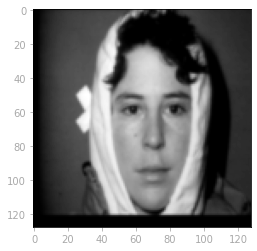

In [3]:
plt.imshow(original_images[0], cmap='gray')
plt.show()

### Preprocessing

In [4]:
min_rows, min_cols = sys.maxsize, sys.maxsize
max_rows, max_cols = 0, 0
for (i, image) in enumerate(original_images):
    r, c = image.shape[0], image.shape[1]    
    min_rows = min(min_rows, r)
    max_rows = max(max_rows, r)
    min_cols = min(min_cols, c)
    max_cols = max(max_cols, c)
    
print("\n==> Least common image size:", min_rows, "x", min_cols, "pixels")


==> Least common image size: 128 x 128 pixels


In [5]:
images = np.array(original_images)
mean_image = np.mean(images, axis=0)

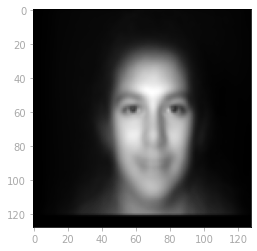

In [6]:
plt.imshow(mean_image, cmap='gray')
plt.show()

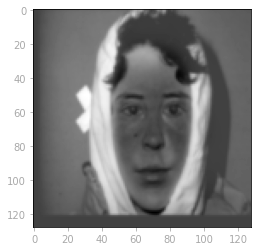

In [7]:
centered_images = np.array([imagen-mean_image for imagen in images])
plt.imshow(centered_images[0], cmap='gray')
plt.show()

In [8]:
# Create m x d data matrix
m = len(images)
d = min_rows * min_cols
X = np.reshape(centered_images, (m, d))

### Applying PCA

In [9]:
U, Sigma, VT = np.linalg.svd(X, full_matrices=False)

In [10]:
# Sanity check on dimensions
print("X:", X.shape)
print("U:", U.shape)
print("Sigma:", Sigma.shape)
print("V^T:", VT.shape)

X: (464, 16384)
U: (464, 464)
Sigma: (464,)
V^T: (464, 16384)


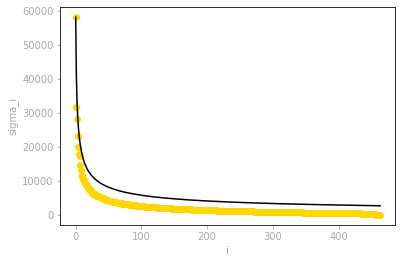

In [11]:
plt.scatter(range(len(Sigma)),Sigma, c='gold')
plt.plot(range(len(Sigma)),[Sigma[0]/((i+1)**0.5) for i in range(len(Sigma))], c='black')
plt.xlabel('i', c='darkgray')
plt.ylabel('sigma_i', c='darkgray')
plt.show()

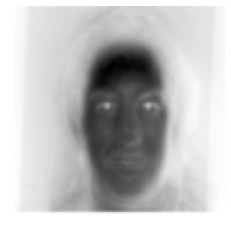

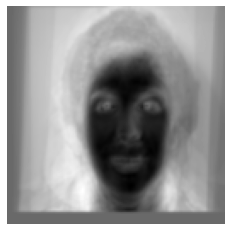

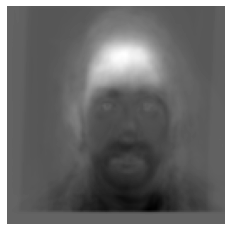

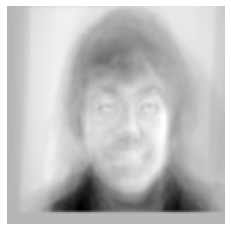

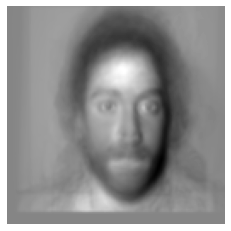

In [12]:
num_components = 5 # Number of principal components
for compo in range(num_components):
    plt.imshow(np.reshape(VT[compo, :],(min_rows, min_cols)), cmap='gray')
    plt.axis('off')
    plt.show()

In [13]:
Y = np.matmul(X, VT[:num_components,:].T)
Y.shape

(464, 5)

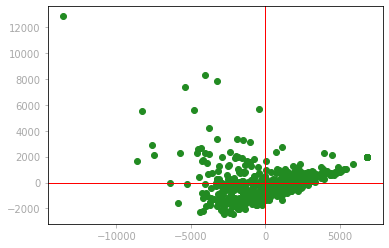

In [14]:
plt.axline((0, 0), (0, 1), linewidth=1, color='r')
plt.axline((0, 0), (1, 0), linewidth=1, color='r')
plt.scatter(Y[:,0],Y[:,1], c='forestgreen')
plt.show()

In [15]:
modelo_kmeans = KMeans(n_clusters=3).fit(np.dstack((Y[:,0],Y[:,1]))[0])

In [16]:
clasiKmeans = modelo_kmeans.predict(np.dstack((Y[:,0],Y[:,1]))[0])

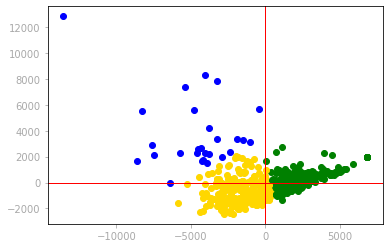

In [17]:
plt.axline((0, 0), (0, 1), linewidth=1, color='r')
plt.axline((0, 0), (1, 0), linewidth=1, color='r')
colores = ['gold','green','blue']
for i,k in enumerate(clasiKmeans):
    plt.scatter(Y[i,0],Y[i,1], c=colores[k])
plt.show()

***

## __2. Face Reconstruction and A  Simple Face Detector__

### Computing the EigenFaces

Step 1: obtain face images (training faces)

In [18]:
corpus = []
basedir = './lfw1000/'
files = []
lsita_imagenes = [x for x in os.listdir(basedir) if os.path.isfile(os.path.join(basedir, x))]
i = 0
while i < 200:
    file = random.choice(lsita_imagenes)
    if file not in files:
        files.append(file)
        corpus.append(np.array(Image.open(basedir+file)))
        i += 1    

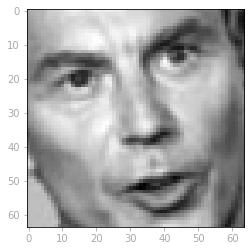

In [19]:
plt.imshow(corpus[0], cmap='gray')
plt.show()

Step 2: represent every image $I_{i}$ as a vector $\Gamma_{i}$

In [20]:
min_rows, min_cols = sys.maxsize, sys.maxsize
max_rows, max_cols = 0, 0
for (i, image) in enumerate(corpus):
    r, c = image.shape[0], image.shape[1]    
    min_rows = min(min_rows, r)
    max_rows = max(max_rows, r)
    min_cols = min(min_cols, c)
    max_cols = max(max_cols, c)

Images = np.array(corpus)

In [21]:
# Create m x d data matrix
m = len(Images)
d = min_rows * min_cols
Gamma = np.reshape(Images, (m, d))

#U, Sigma, VT = np.linalg.svd(Gamma, full_matrices=False)

In [22]:
# Sanity check on dimensions
print("Gamma:", Gamma.shape)
#print("U:", U.shape)
#print("Sigma:", Sigma.shape)
#print("V^T:", VT.shape)

Gamma: (182, 4096)


Step 3: compute the average face vector $\Psi : \Psi = \frac{1}{M} \sum \limits _{i=1} ^{M} \Gamma_{i} $

In [28]:
Psi = np.mean(Gamma, axis=0)

Step 4: subtract the mean face: $\Phi_{i} = \Gamma_{i} - \Psi $

In [38]:
Phi = np.array([imagen-Psi for imagen in Gamma])
Phi.shape

(182, 4096)

Step 5: compute the covariance matrix C:

$ C = \frac{1}{M} \sum \limits _{n=1} ^{M} \Phi _{n} \Phi _{n}^{T} = AA^{T} (N^2xN^2 matrix) $

$ where A = [ \Phi_{1} \Phi_{2} … \Phi_{M} ] (N^2xM matrix) $


In [52]:
C = np.transpose(Phi).dot(Phi)
C.shape

(4096, 4096)

Step 6: compute the eigenvectors $ u_{i}$ of $ AA^{T}$

In [54]:
# AA^T is very large
# Consider the matrix A^TA
ATA = Phi.dot(np.transpose(Phi))
ATA.shape

(182, 182)

In [ ]:
# compute the eigenvectors vi of ATA

Step 7: keep only K eigenvectors



### Referencias:

https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/
https://pillow.readthedocs.io/en/stable/reference/Image.html